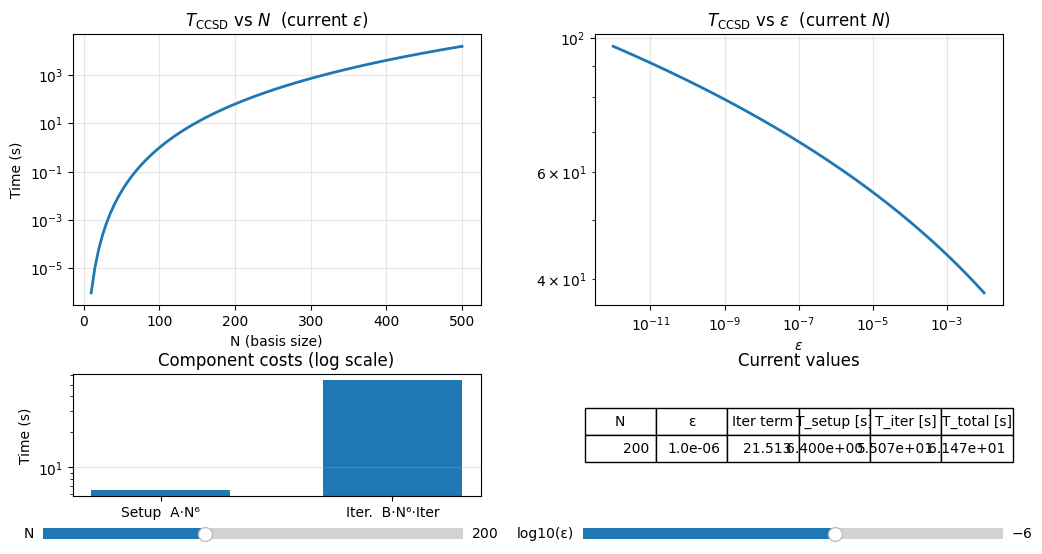

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

# ------------------ Constants (CCSD) ------------------
A = 1e-13    # setup intermediates      ~ N^6
B = 4e-14    # per-iteration contractions ~ N^6
alpha_cc = 1.0
beta_cc  = 10.0
E0 = 1e-1

# ------------------ Model ------------------
def iter_term(eps):
    # vectorized for scalars/arrays
    return np.maximum(0.0, alpha_cc * np.log(E0 / eps)) + beta_cc

def T_total(N, eps):
    # T_CCSD(N, ε) = A N^6 + B N^6 [max(0, α ln(E0/ε)) + β]
    return N**6 * (A + B * iter_term(eps))

def T_setup(N):
    return A * N**6

def T_iter(N, eps):
    return B * N**6 * iter_term(eps)

# ------------------ Figure layout ------------------
plt.close("all")
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(2, 2, height_ratios=[4, 1.8], wspace=0.28, hspace=0.35)

axN   = fig.add_subplot(gs[0, 0])   # T vs N
axE   = fig.add_subplot(gs[0, 1])   # T vs eps
axBar = fig.add_subplot(gs[1, 0])   # separate bars
axTbl = fig.add_subplot(gs[1, 1])   # numeric table

# ------------------ Defaults ------------------
N0 = 200
logeps0 = -6.0
eps0 = 10**logeps0

# ------------------ Left: T vs N ------------------
Nmin, Nmax = 10, 500
Ns = np.arange(Nmin, Nmax + 1, 5)
lineN, = axN.plot(Ns, T_total(Ns, eps0), lw=2)
axN.set_title(r"$T_{\rm CCSD}$ vs $N$  (current $\varepsilon$)")
axN.set_xlabel("N (basis size)")
axN.set_ylabel("Time (s)")
axN.set_yscale("log")
axN.grid(True, alpha=0.3)

# ------------------ Right: T vs ε ------------------
logeps_min, logeps_max = -12, -2
logeps = np.linspace(logeps_min, logeps_max, 600)
eps_grid = 10**logeps
lineE, = axE.plot(eps_grid, T_total(N0, eps_grid), lw=2)
axE.set_xscale("log")
axE.set_yscale("log")
axE.set_xlabel(r"$\varepsilon$")
axE.set_title(r"$T_{\rm CCSD}$ vs $\varepsilon$  (current $N$)")
axE.grid(True, alpha=0.3)

# ------------------ Bottom row helpers ------------------
def draw_bottom(N_val, eps_val):
    # ---- Bars (separate; log y) ----
    axBar.clear()
    t_setup = T_setup(N_val)
    t_iter  = T_iter(N_val, eps_val)
    axBar.bar([0, 1], [t_setup, t_iter], width=0.6)
    axBar.set_xticks([0, 1], ["Setup  A·N⁶", "Iter.  B·N⁶·Iter"])
    axBar.set_ylabel("Time (s)")
    axBar.set_yscale("log")
    axBar.grid(True, axis="y", alpha=0.3)
    axBar.set_title("Component costs (log scale)")

    # ---- Table (clean readout) ----
    axTbl.clear(); axTbl.axis("off")
    it = iter_term(eps_val)
    tt = t_setup + t_iter
    cols = ["N", "ε", "Iter term", "T_setup [s]", "T_iter [s]", "T_total [s]"]
    row  = [f"{int(N_val)}", f"{eps_val:.1e}", f"{it:.3f}",
            f"{t_setup:.3e}", f"{t_iter:.3e}", f"{tt:.3e}"]
    table = axTbl.table(cellText=[row], colLabels=cols, loc="center")
    table.auto_set_font_size(False); table.set_fontsize(10); table.scale(1.05, 1.6)
    axTbl.set_title("Current values")

draw_bottom(N0, eps0)

# ------------------ Sliders ------------------
axN_slider   = fig.add_axes([0.10, 0.03, 0.35, 0.035])
axEps_slider = fig.add_axes([0.55, 0.03, 0.35, 0.035])

sN = Slider(axN_slider, "N", Nmin, Nmax, valinit=N0, valstep=5)
sLogEps = Slider(axEps_slider, r"log10(ε)", logeps_min, logeps_max, valinit=logeps0)

# ------------------ Update ------------------
def update(_):
    Nval = int(sN.val)
    epsval = 10**(sLogEps.val)

    lineN.set_ydata(T_total(Ns, epsval))     # T vs N (current ε)
    lineE.set_ydata(T_total(Nval, eps_grid)) # T vs ε (current N)
    draw_bottom(Nval, epsval)
    fig.canvas.draw_idle()

sN.on_changed(update)
sLogEps.on_changed(update)

plt.show()
